---
title: "Orientation"
---

## Setup

In [9]:
#| hide
import polars as pl
from ids_finder.utils.basic import load_catalog

from beforerr.r import py2rpy_polars
import rpy2.robjects as robjects

from ids_finder.pipelines.project.pipeline import process_events_l2
from ids_finder.utils.polars import pl_norm

import hvplot.polars
import panel as pn
import warnings

# Suppress specific FutureWarning from pandas in Holoviews
warnings.filterwarnings(
    "ignore", category=FutureWarning, module="holoviews.core.data.pandas"
)


In [2]:
#| hide
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

catalog = load_catalog()

r = robjects.r
r.source('utils.R')
conv_pl = py2rpy_polars()

[11/30/23 13:28:07] WARNING  KedroDeprecationWarning: 'AbstractVersionedDataSet' has been renamed to  ]8;id=506926;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=181340;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             'AbstractVersionedDataset', and the alias will be removed in Kedro                    
                             0.19.0                                                                                
                                                                                                                   

                    WARNING  R[write to console]:                                                  ]8;id=123361;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=889366;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                             Attaching package: ‘dplyr’                                                            
                                                                                                                   
                                                                                                                   

                    WARNING  R[write to console]: The following objects are masked from            ]8;id=245998;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=283718;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                             ‘package:stats’:                                                                      
                                                                                                                   
                                 filter, lag                                                                       
                                                                                                                   
                                                                                                                   

                    WARNING  R[write to console]: The following objects are masked from            ]8;id=555303;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py\callbacks.py]8;;\:]8;id=497611;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface_lib/callbacks.py#124\124]8;;\
                             ‘package:base’:                                                                       
                                                                                                                   
                                 intersect, setdiff, setequal, union                                               
                                                                                                                   
                                                                                                                   

In [3]:
all_events_l1: pl.DataFrame = catalog.load("events.l1.ALL_sw_ts_1s_tau_60s").collect()

cols = ["dB_x_norm", "dB_y_norm", "dB_z_norm"]
all_events_l1 = (
    all_events_l1.with_columns(dB=pl_norm(cols))
    .with_columns(
        dB_x_n2=pl.col("dB_x_norm") / pl.col("dB"),
        dB_y_n2=pl.col("dB_y_norm") / pl.col("dB"),
        dB_z_n2=pl.col("dB_z_norm") / pl.col("dB"),
    )
    .with_columns(
        theta_dB=pl.col("dB_z_n2").arccos().degrees(),
        phi_dB=(pl.col("dB_y_n2") / pl.col("dB_x_n2")).arctan().degrees(),
    )
)

JNO_events_l1 = all_events_l1.filter(pl.col("sat") == "JNO")
other_events_l1 = all_events_l1.filter(pl.col("sat") != "JNO")
all_events_l2 = all_events_l1.pipe(process_events_l2)

[11/30/23 13:28:08] INFO     Loading data from 'events.l1.ALL_sw_ts_1s_tau_60s'                 ]8;id=559183;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=458208;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

In [4]:
%R -i JNO_events_l1 -c conv_pl
%R -i all_events_l1 -c conv_pl
%R -i other_events_l1 -c conv_pl
%R -i all_events_l2 -c conv_pl

In [5]:
%%R
probs <- c(0.99, 0.9, 0.7, 0.5, 0.3, 0.1)

plot_plot <- function(df, x, y, type = "hdr", facets = NULL, color = NULL) {
  p <- ggplot(df, aes(x = .data[[x]], y = .data[[y]]) ) +
    scale_color_okabeito(palette = "black_first")


  if (!is.null(facets)) {
    p <- p + facet_wrap(vars(.data[[facets]]))
  }

  if (type == "hdr") {
    p <- p + geom_hdr_lines(
      aes_string(color = color),
      probs = probs
    )
  } else if (type == "density") {
    p <- p + geom_density_2d_filled()
  }

  return (p)
}

## $\theta_{n,b}$

In [6]:
all_events_l1['theta_n_b'].describe()

statistic,value
str,f64
"""count""",280740.0
"""null_count""",0.0
"""mean""",89.565227
"""std""",24.914059
"""min""",0.046898
"""25%""",78.403561
"""50%""",89.87696
"""75%""",100.96636
"""max""",179.86788


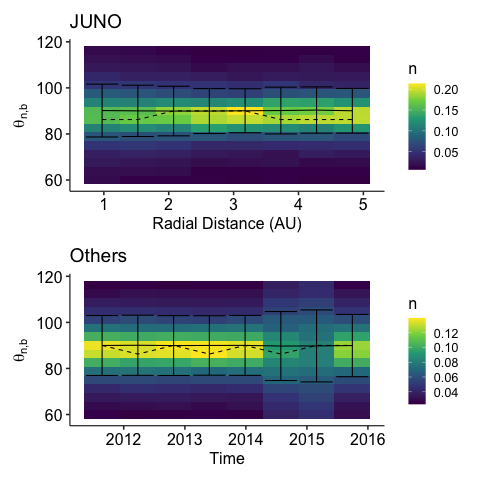

In [5]:
%%R
y <- "theta_n_b"
ylab <- expression(theta["n,b"])
y_lim <- c(60, 120)
p1 <- plot_dist(y=y, ylab=ylab, y_lim = y_lim, y_log=FALSE)
p1

## Change of magnetic field

Saving 16.7 x 16.7 in image
Saving 16.7 x 16.7 in image


In addition: Warning message:
`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


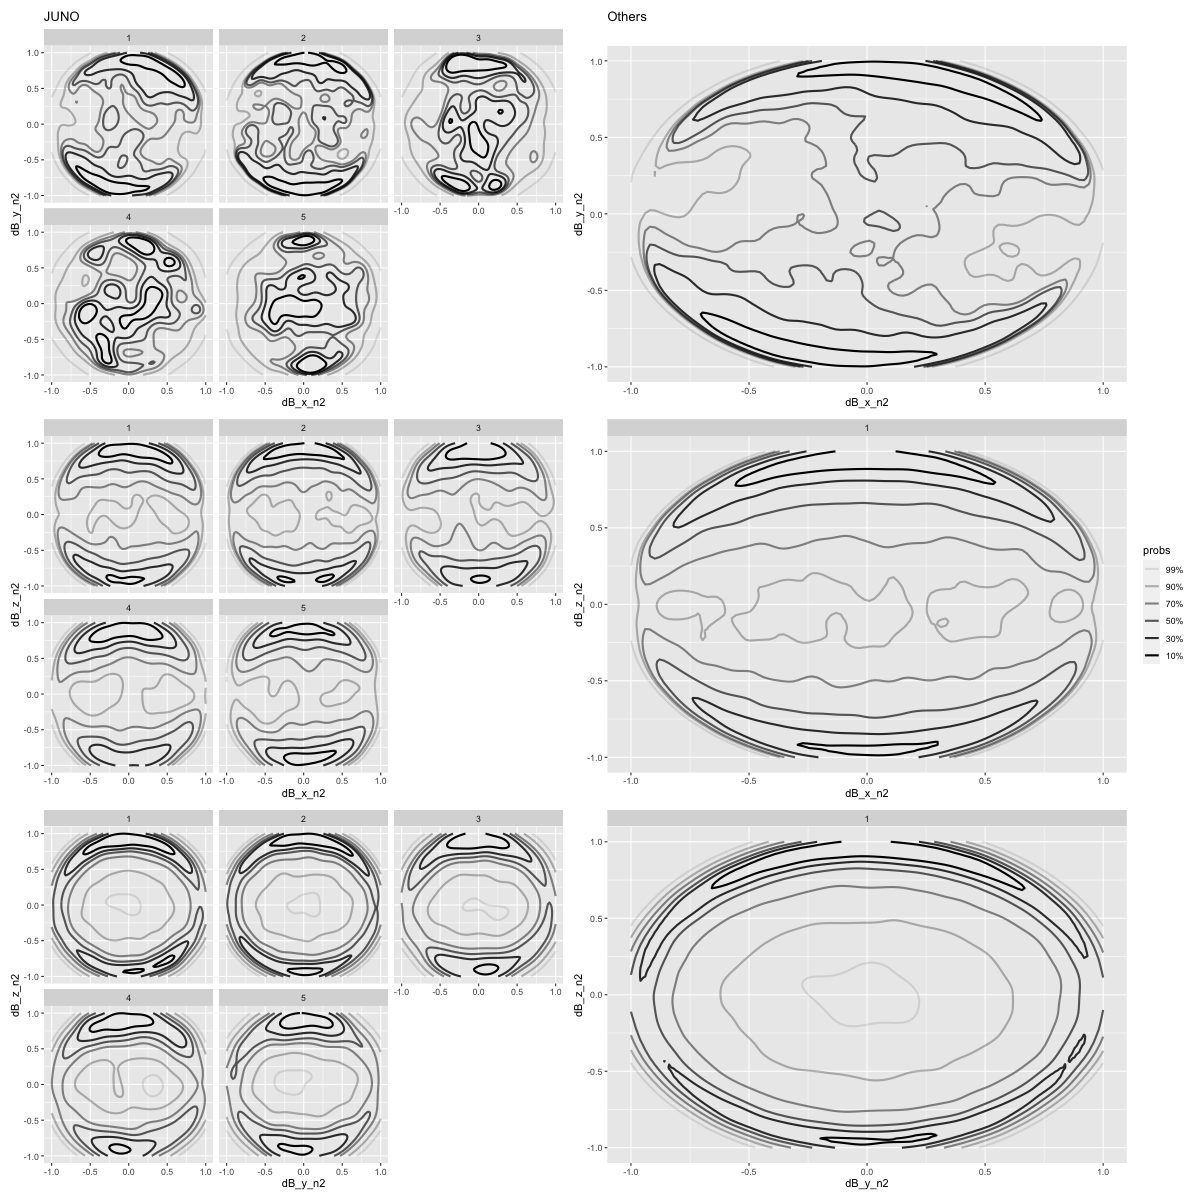

In [8]:
%%R -w 1200 -h 1200

x <- "dB_x_n2"
y <- "dB_y_n2"
z <- "dB_z_n2"
facets <- "r_bin"

p1_JNO <- plot_plot(JNO_events_l1, x, y, facets = facets) + ggtitle("JUNO") + theme(legend.position = "none")
p1_other <- plot_plot(other_events_l1, x, y)  + ggtitle("Others") + theme(legend.position = "none")

p2_JNO <- plot_plot(JNO_events_l1, x, z, facets = facets) + theme(legend.position = "none")
p2_other <- plot_plot(other_events_l1, x, z, facets = facets)

p3_JNO <- plot_plot(JNO_events_l1, y, z, facets = facets) + theme(legend.position = "none")
p3_other <- plot_plot(other_events_l1, y, z, facets = facets) + theme(legend.position = "none")


p <- (p1_JNO | p1_other) / (p2_JNO | p2_other) / (p3_JNO | p3_other)
save_plot("orientation/orientation_dB_xyz")
p

In [9]:
(JNO_events_l1.hvplot.kde('theta_dB', by="r_bin",subplots=True).cols(1) + JNO_events_l1.hvplot.kde('phi_dB', by="r_bin",subplots=True).cols(1))

:Layout
   .NdLayout.I  :NdLayout   [r_bin]
      :Distribution   [theta_dB]   (Density)
   .NdLayout.II :NdLayout   [r_bin]
      :Distribution   [phi_dB]   (Density)

In [42]:
(all_events_l1.hvplot.hist('theta_dB', by="sat",subplots=True).cols(1) + all_events_l1.hvplot.hist('phi_dB', by="sat",subplots=True).cols(1))

:Layout
   .NdLayout.I  :NdLayout   [sat]
      :Histogram   [theta_dB]   (theta_dB_count)
   .NdLayout.II :NdLayout   [sat]
      :Histogram   [phi_dB]   (phi_dB_count)

## Normal direction obtained from dot product

In [8]:
def dist_plot(df: pl.LazyFrame, var, by=None):
    return df.hvplot.density(var, by=by, subplots=True, width=300, height=300)

Most discontinuities has normal direction with large $k_x$ and small $k_y$ with evenly distributed $k_z$.

In [10]:
# (dist_plot(JNO_events_l1, "k_x", by="r_bin") +  dist_plot(other_events_l1, "k_x")).cols(3) + (dist_plot(JNO_events_l1, "k_y", by="r_bin") +  dist_plot(other_events_l1, "k_y")).cols(3)

pn.Column(
    dist_plot(JNO_events_l1, "k_x", by="r_bin").cols(5) +  dist_plot(other_events_l1, "k_x"),
    dist_plot(JNO_events_l1, "k_y", by="r_bin").cols(5) +  dist_plot(other_events_l1, "k_y"),
    dist_plot(JNO_events_l1, "k_z", by="r_bin").cols(5) +  dist_plot(other_events_l1, "k_z"),
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'5d5cc544-001c-4621-9e4e-55cb752166ba': {'defs': …

Saving 16.7 x 16.7 in image
Saving 16.7 x 16.7 in image


In addition: Warning message:
`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


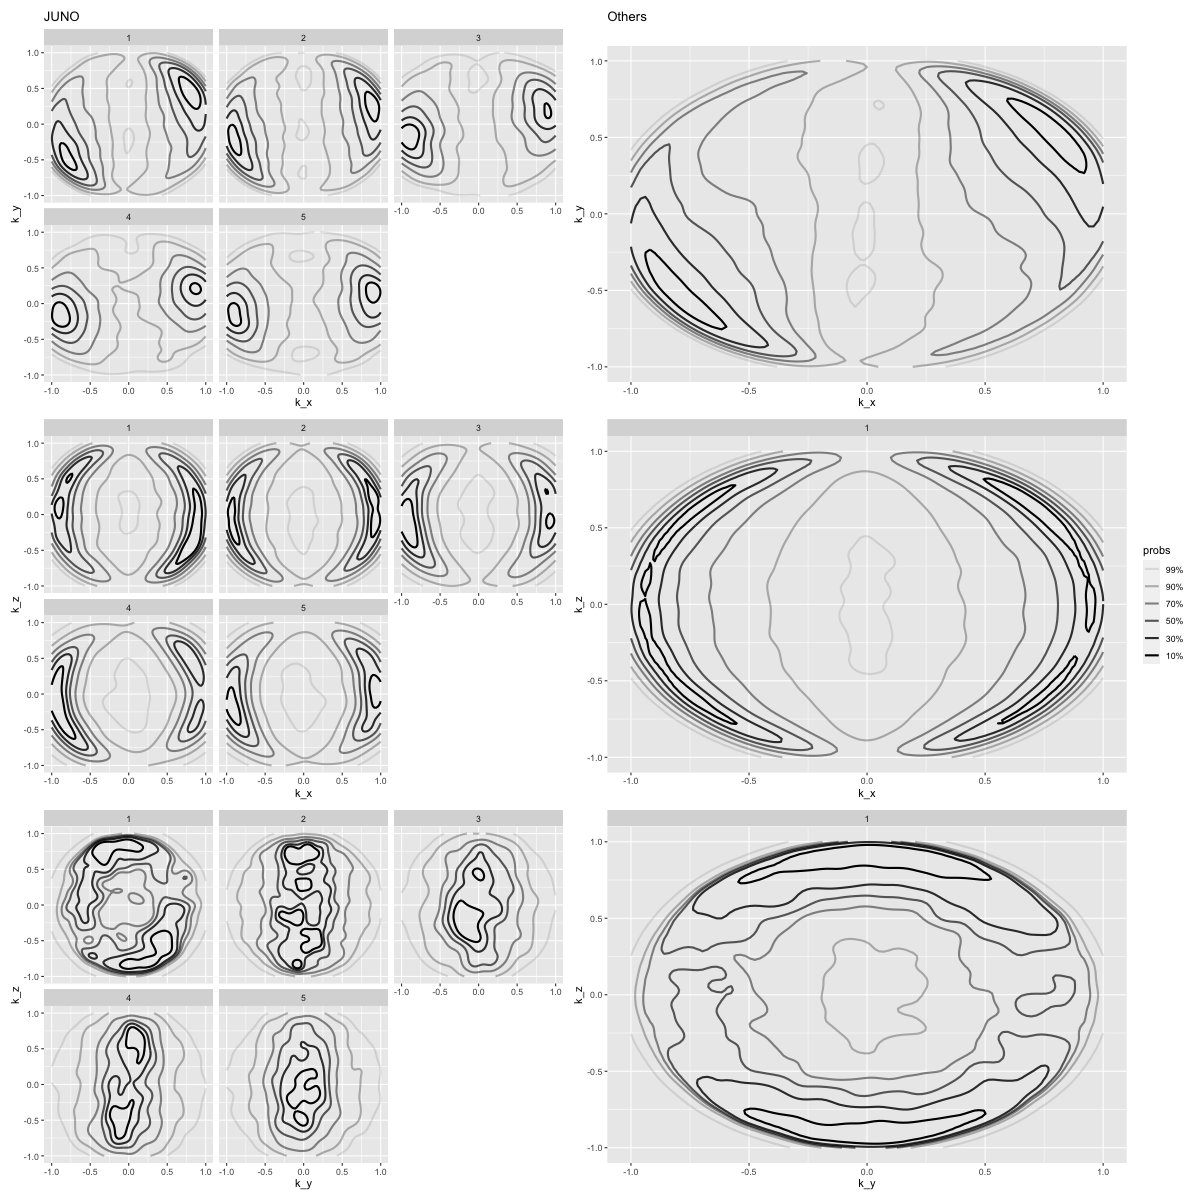

In [11]:
%%R -w 1200 -h 1200

x <- "k_x"
y <- "k_y"
z <- "k_z"
facets <- "r_bin"

p1_JNO <- plot_plot(JNO_events_l1, x, y, facets = facets) + ggtitle("JUNO") + theme(legend.position = "none")
p1_other <- plot_plot(other_events_l1, x, y)  + ggtitle("Others") + theme(legend.position = "none")

p2_JNO <- plot_plot(JNO_events_l1, x, z, facets = facets) + theme(legend.position = "none")
p2_other <- plot_plot(other_events_l1, x, z, facets = facets)

p3_JNO <- plot_plot(JNO_events_l1, y, z, facets = facets) + theme(legend.position = "none")
p3_other <- plot_plot(other_events_l1, y, z, facets = facets) + theme(legend.position = "none")


p <- (p1_JNO | p1_other) / (p2_JNO | p2_other) / (p3_JNO | p3_other)
save_plot("orientation/orientation_k_xyz")
p

## $V_l$

Saving 16.7 x 16.7 in image


Saving 16.7 x 16.7 in image


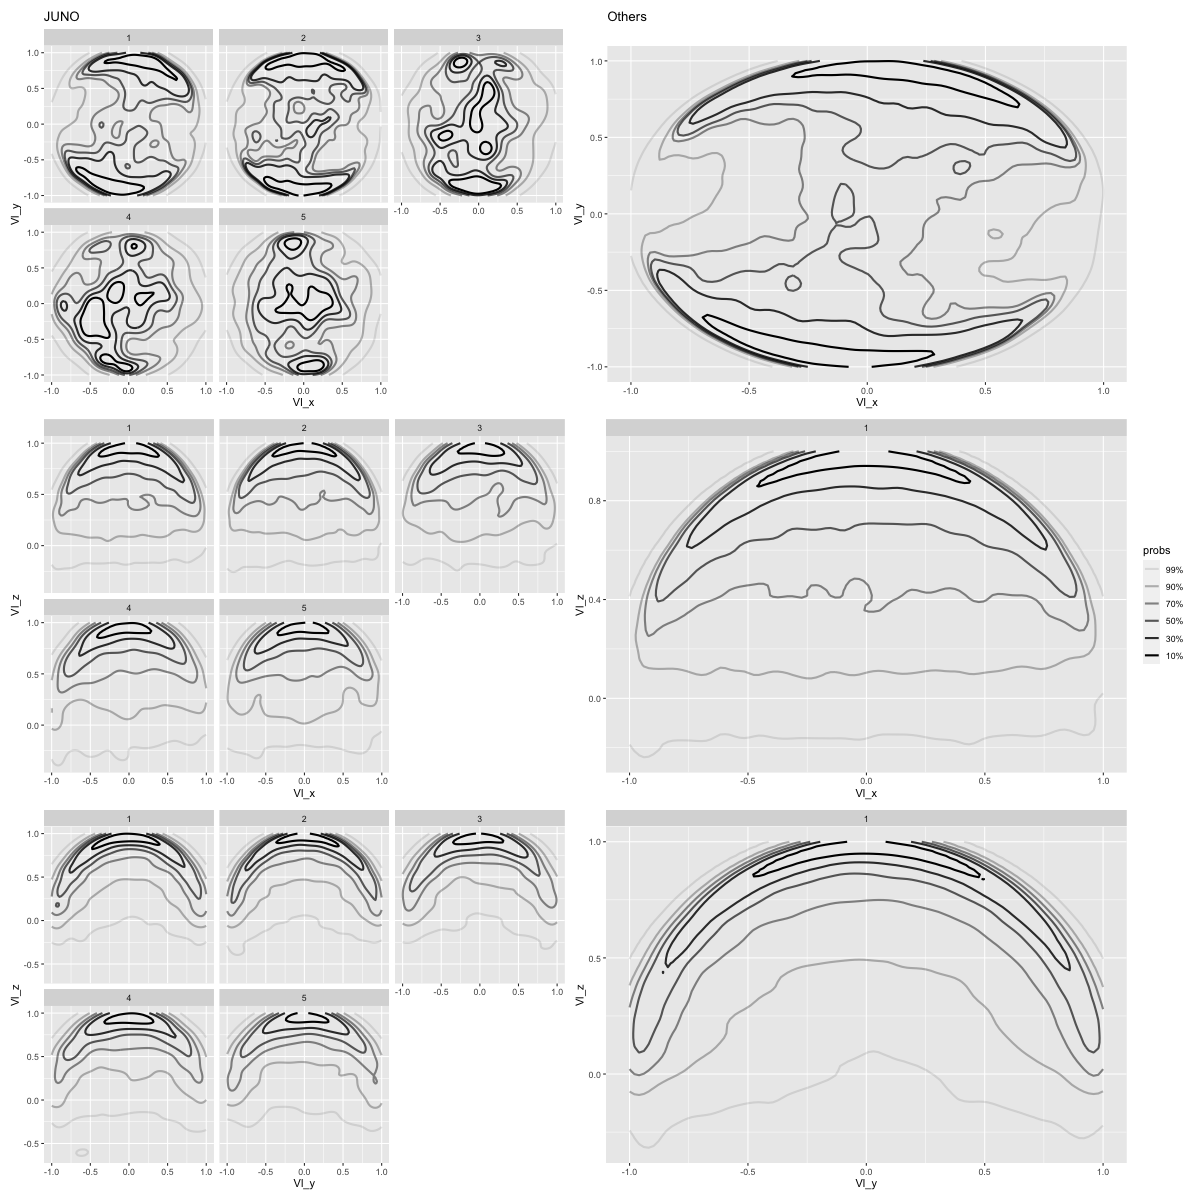

In [12]:
%%R -w 1200 -h 1200

x <- "Vl_x"
y <- "Vl_y"
z <- "Vl_z"
facets <- "r_bin"

p1_JNO <- plot_plot(JNO_events_l1, x, y, facets = facets) + ggtitle("JUNO") + theme(legend.position = "none")
p1_other <- plot_plot(other_events_l1, x, y)  + ggtitle("Others") + theme(legend.position = "none")

p2_JNO <- plot_plot(JNO_events_l1, x, z, facets = facets) + theme(legend.position = "none")
p2_other <- plot_plot(other_events_l1, x, z, facets = facets)

p3_JNO <- plot_plot(JNO_events_l1, y, z, facets = facets) + theme(legend.position = "none")
p3_other <- plot_plot(other_events_l1, y, z, facets = facets) + theme(legend.position = "none")


p <- (p1_JNO | p1_other) / (p2_JNO | p2_other) / (p3_JNO | p3_other)
save_plot("orientation/orientation_Vl_xyz")
p


### Evolution

In [ ]:
%%R
x_var <- "time"
y_vars <- c("k_x", "k_y", "k_z")
xlab <- "Time"
ylabs <- c("Orientation (k_x)", "k_y", "k_z")
p <- plot_util(all_events_l2, x_var = x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("orientation/orientation_k_time")

x_var <- "ref_radial_distance"
xlab <- "Referred Radial Distance (AU)"
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("orientation/orientation_k_r")

x_var <- "ref_radial_distance"
y_vars <- c("Vl_x", "Vl_y", "Vl_z")
xlab <- "Referred Radial Distance (AU)"
ylabs <- c("Orientation (l_x)", "l_y", "l_z")
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("orientation/orientation_l_r")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: There were 30 warnings (use warnings() to see them)


In [ ]:
%%R
x_col <- "radial_distance"
y_col <- "k_x"
y_lim <- NULL
x_bins <- 16
y_bins <- 32
xlab <- "Radial Distance (AU)"
ylab <- "Orientation (k_x)"
p <- plot_binned_data(JNO_events_l1, x_col = x_col, y_col = y_col, x_bins = x_bins, y_bins=y_bins, y_lim = y_lim, log_y = FALSE)
p <- p + labs(x = xlab, y= ylab)
save_plot("orientation/orientation_kx_r_dist")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
